In [ ]:
filtered=sc.read('Capillaries_INCITE_object.h5ad')

In [ ]:
filtered.obs['did'] = filtered.obs['DiseaseState'].astype(str) + "_" + filtered.obs['SampleID'].astype(str) + filtered.obs['Sex'].astype(str)
# Compute the cell counts for each did
cell_counts = filtered.obs['did'].value_counts()

# Map these counts to the did column in adata.obs
filtered.obs['cell_count'] = filtered.obs['did'].map(cell_counts)


In [5]:
filtered.obs['did'] = filtered.obs['DiseaseState'].astype(str) + "_" + filtered.obs['SampleID'].astype(str) + filtered.obs['Sex'].astype(str)
# Compute the cell counts for each did
cell_counts = filtered.obs['did'].value_counts()

# Map these counts to the did column in adata.obs
filtered.obs['cell_count'] = filtered.obs['did'].map(cell_counts)


In [6]:
filtered

AnnData object with n_obs × n_vars = 23152 × 25072
    obs: 'date', 'souporcell_status', 'souporcell_assignment', 'demux_type', 'assignment', 'hashtag_counts', 'Demux2_assignment', 'Demux2_droplet_type', 'batch', 'prep_type', 'Demux2_plus_demuxem_assignment', 'total_counts_TDP', 'total_counts_KHSRP', 'total_counts_H3', 'total_counts_NFKB', 'total_counts_ORF1', 'total_counts_PTBP1', 'total_counts_ORF2', 'total_counts_STAT3', 'total_counts_BCATENIN', 'total_counts_HNRNPA1', 'total_counts_SRRM2', 'total_counts_MATR3', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'new_status', 'Exclusion', 'date.1', 'bank', 'region', 'Sex', 'Age', 'DiseaseState', 'SampleID', 'PostmortemInterval', 'NIHBankRIN', 'MurphyLabRIN', 'JoinedRIN', 'FACs_NeuN_Percentage', 'FACs_ErgHi_Percentage', 'FACs_ErgLo_Percentage', 'Sequence_ApoE_allele', 'Pathology_BrainWeight (g)', 'SampleID_Gel', 'Gel', 'Vcam_rel_to_Amyl_Gapdh', 'Vcam_topband', 'Vcam_65', 'Vcam_32', 'Vcam_topband_rel_to_gapdh', 'Vcam65_

In [21]:
ind_count

,SampleID,DiseaseState,leiden_04,counts
0,946,OldCtrl,3,64
1,1081,ALS,3,17
2,1312,AD,3,2
3,1439,AD,3,2
4,1486,YngCtrl,3,46
5,1710,YngCtrl,3,10
6,1712,YngCtrl,3,4
7,1843,YngCtrl,3,26
8,4513,AD,3,163
9,4522,AD,3,17


In [ ]:
disease_colors <- c(
  "AD" = "#FF0000",      # Bright red
  "OldCtrl" = "#0000FF", # Bright blue
  "ALS" = "#D32F2F",     # Darker shade of red
  "YngCtrl" = "#4682B4", # Steel blue
  "FTD" = "#E57373"      # Light muted red
)


Cluster 4 - Spearman correlation: 0.6129167409736499 P-value: 0.0
Cluster 1 - Spearman correlation: 0.3705092779074114 P-value: 0.0
Cluster 2 - Spearman correlation: -0.359098858912206 P-value: 0.0
Cluster 3 - Spearman correlation: -0.5521586013977737 P-value: 0.0
Cluster 0 - Spearman correlation: -0.09273029558333015 P-value: 2.220492793473298e-45


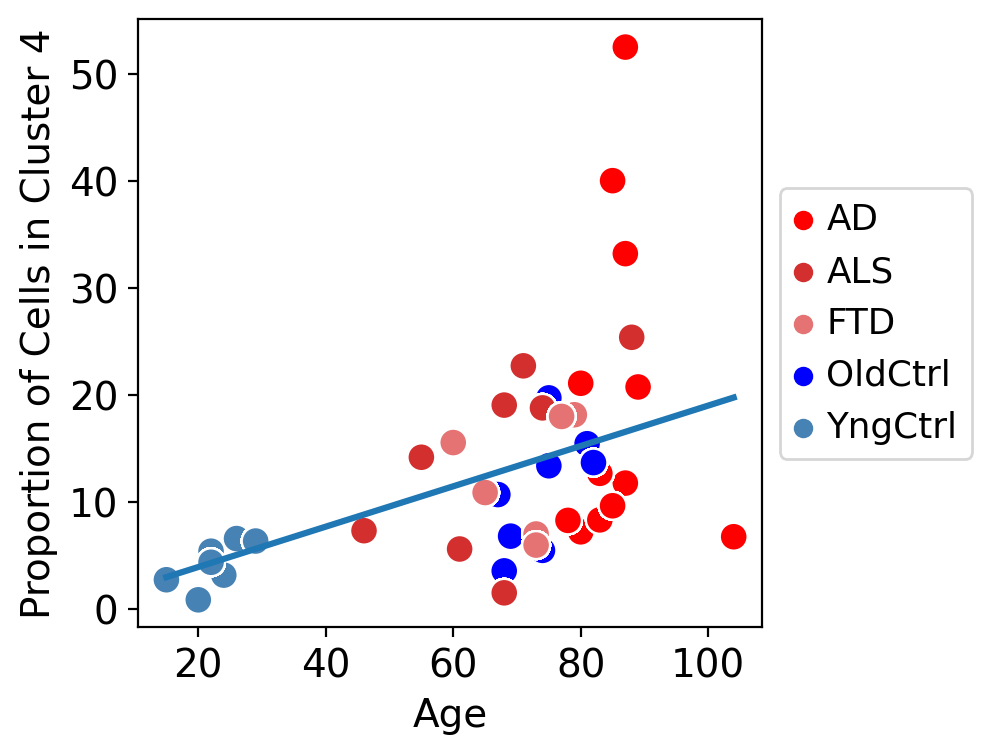

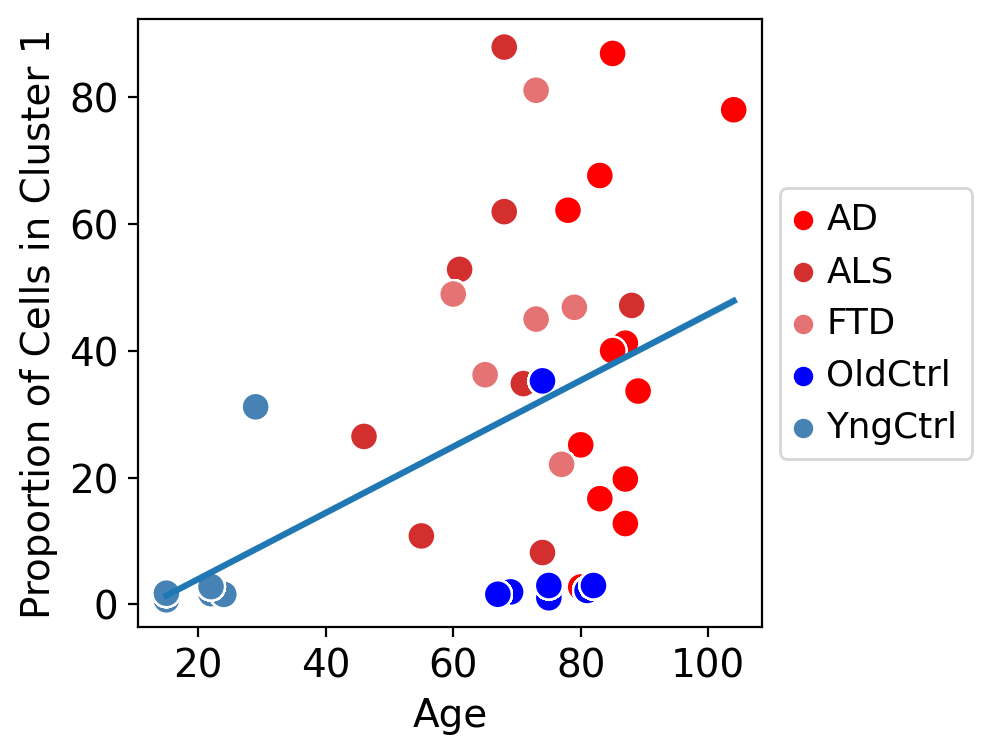

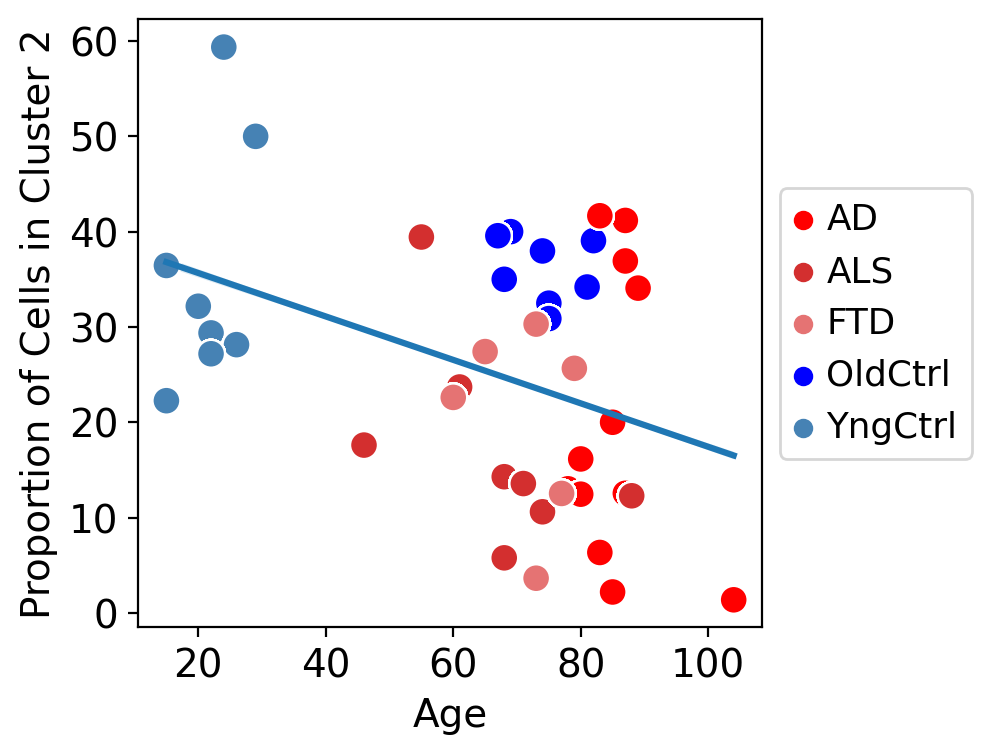

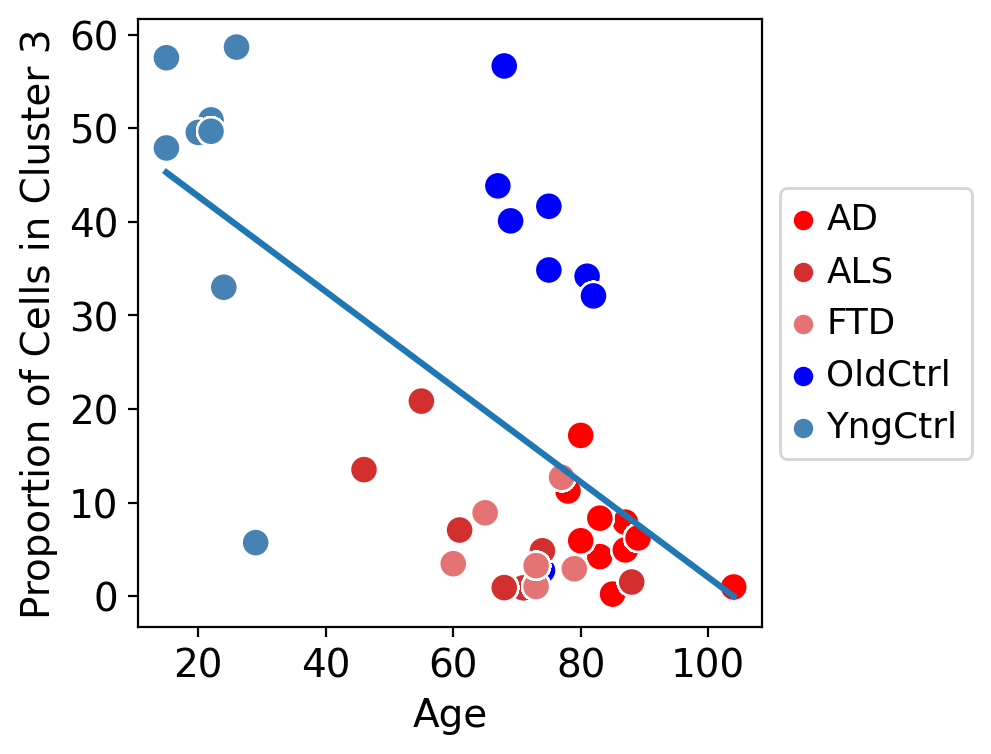

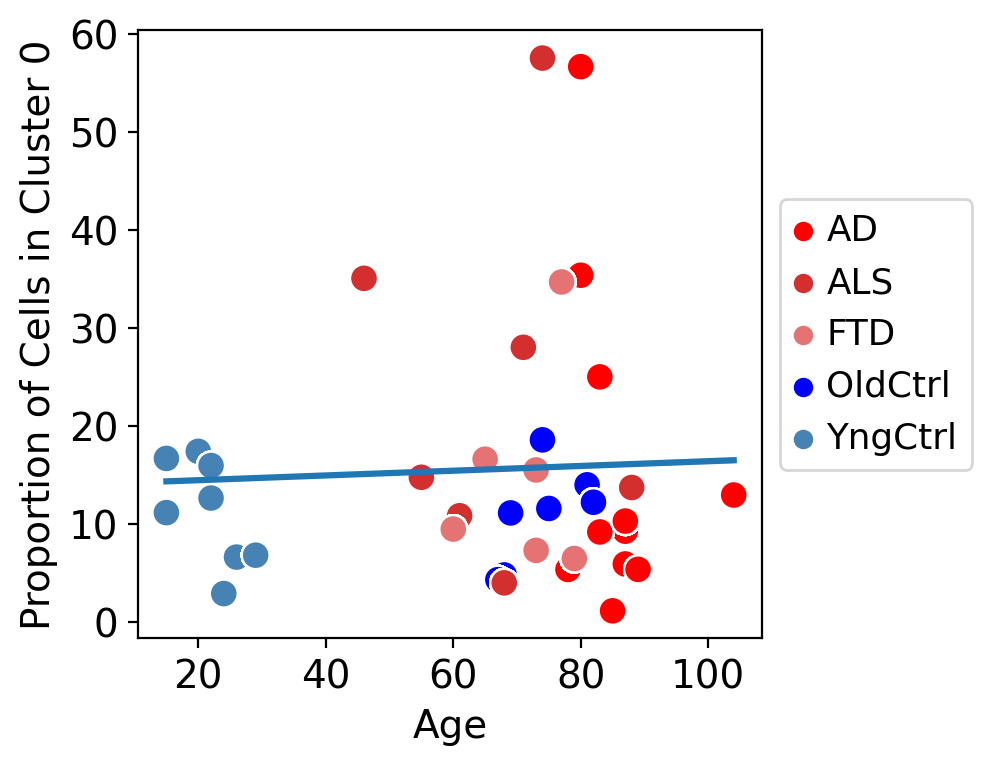

In [47]:
sc.settings.set_figure_params(dpi=100)

all_ind_count = filtered.obs.groupby('SampleID').size().reset_index(name='all_count_sum')

for cluster in filtered.obs['final_leiden'].unique():
    # Subset data for current cluster
    c = filtered[filtered.obs["final_leiden"].isin([cluster])]
    
    # Compute counts for this cluster
    ind_count = c.obs.groupby(['SampleID', 'DiseaseState', 'final_leiden'], observed=True).size().reset_index(name='counts')
   # ind_count = ind_count[ind_count['DiseaseState'] != 'YngCtrl']
    ind_count['counts'] = ind_count['counts'].astype('float')
    mapped_series = ind_count['SampleID'].map(all_ind_count.set_index('SampleID')['all_count_sum'])
    mapped_series = mapped_series.astype('float64')

    ind_perc = (ind_count['counts'] / mapped_series) * 100
    # Add percentage column to the count data
    ind_count['cluster_perc'] = ind_perc
    
    # Merge with Age column
    ind_count = pd.merge(ind_count, filtered.obs[['SampleID', 'Age']], on='SampleID', how='left')
    
    # Convert 'Age' column to numeric
    ind_count['Age'] = pd.to_numeric(ind_count['Age'], errors='coerce')
    ind_count['Age'] = pd.to_numeric(ind_count['Age'], errors='coerce')
    ind_count['cluster_perc'] = pd.to_numeric(ind_count['cluster_perc'], errors='coerce')

    # Plot
    plt.figure()
    sns.regplot(x='Age', y='cluster_perc', data=ind_count, ci=99, scatter=False)  # Added ci=95 here
    ax = sns.scatterplot(x='Age', y='cluster_perc', hue='DiseaseState', data=ind_count, 
                         palette = ["#FF0000", "#D32F2F", "#E57373", '#0000FF', '#4682B4'], s=100)
    #'#5c8c44', '#a724f2', '#bd4dca', '#cc62cb', '#f7b363'
   # "#E63946", "#DAA520", "#A8DADC", "#457B9D", "#1D3557"
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel(f'Proportion of Cells in Cluster {cluster}')
    plt.xlabel('Age')
    plt.grid(False)
    plt.savefig(f'Cluster_{cluster}_vs_Age.png', bbox_inches='tight')
    
    # Spearman correlation
    correlation, p_value = stats.spearmanr(ind_count['Age'], ind_count['cluster_perc'].fillna(0))
    print(f"Cluster {cluster} - Spearman correlation:", correlation, "P-value:", p_value)
